In [1]:
import pandas as pd
import ast
import numpy as np
import scipy.stats as stats 
import statsmodels.stats.api as sms
import seaborn as sns
import matplotlib.pyplot as plt
import os, glob
import pickle
from statsmodels.stats.multitest import multipletests
plt.rcParams["font.family"] = "Times New Roman"

# Change current working directory to the base

In [2]:
os.chdir('../')
os.getcwd()

'/Users/xehu/Desktop/Team Process Mapping/tpm-horse-race-modeling'

# Plot Means with Confidence Intervans and T-Tests
Create a bar plot to compare the Q^2 for different models.

Expected inputs:
- **evaluation_output_list**: a list of paths to different model evaluations (this is the output file of the `HorseRaceModelEvaluator` class.)
- **save_path**: the path where the plots should be saved.
- **title_appendix**: a descriptor for appending on the title.

Optional inputs:
- **confidence_level**: the level of drawing the confidence intervals for the bars (defaults to 95%)
- **alpha**: the level of alpha for comparing model Q^2 (defaults to 0.05).

In [3]:
def plot_means_with_confidence_intervals_and_ttests(evaluation_output_list, save_path, title_appendix = "", confidence_level=0.95, alpha=0.05):
	# Calculate means and confidence intervals

	# Read in the evaluation outputs as a list of lists
	observation_lists = [[ast.literal_eval(x.strip())["q^2"] for x in open(path, "r").readlines()] for path in evaluation_output_list]

	# Create cleaned-up
	labels = [name for name in evaluation_output_list]

	label_mapping = {
		"composition": "Team Composition", 
		"size": "Team Size",
		"task_attr": "Task Attributes", 
		"task_complexity": "Task Complexity", 
		"comms": "Communication Process"
	}
	# Transform the labels according to the label_mapping.
	transform_label = lambda label: '_'.join([label_mapping[key] for key in label_mapping if key in label])
	labels = [transform_label(label) for label in labels]
	
	# Sort the observation_lists and labels based on the desired order
	desired_order = ["Team Composition", "Team Size", "Task Attributes", "Task Complexity", "Communication Process"]
	observation_lists, labels = zip(*sorted(zip(observation_lists, labels), key=lambda x: desired_order.index(x[1])))

	means = [np.mean(observation) for observation in observation_lists]
	errors = [(sms.DescrStatsW(observation).tconfint_mean()[1] - sms.DescrStatsW(observation).tconfint_mean()[0]) / 2. for observation in observation_lists]
	colors = plt.cm.tab20(np.arange(len(labels)))

	# Plot the bar graph with error bars
	plt.figure(figsize=(12, 8))
	plt.bar(range(len(means)), means, yerr=errors, align='center', alpha=0.7, ecolor='black', color=colors, capsize=10)

	# Add labels and title
	plt.xticks(range(len(means)), labels, rotation=45, ha="right")  # Rotate x-axis labels by 45 degrees
	plt.ylabel('Prediction Q^2', size = 16)
	plt.title('Predictive Power of Models; Pairwise t-test with B-H Correction' + title_appendix, size = 18)

	# Perform pairwise t-tests
	HEIGHT_MULTIPLIER = 0.1

	p_values = []
	i_s = []
	j_s = []

	line_height = np.mean(max(observation_lists)) * 0.1
	for i in range(len(observation_lists)):
		for j in range(i + 1, len(observation_lists)):
			t_stat, p_value = stats.ttest_ind(observation_lists[i], observation_lists[j])
			p_values.append(p_value)
			i_s.append(i)
			j_s.append(j)

	# Correct p-values for multiple comparisons using Benjamini-Hochberg procedure
	_, p_values_corrected, _, _ = multipletests(p_values, alpha=alpha, method='fdr_bh')

	# Draw horizontal bar between compared groups by using the corrected p-value
	for k in range(len(p_values_corrected)):

		p_value = p_values_corrected[k]
		i = i_s[k]
		j = j_s[k]

		# if p_value < alpha:
		if p_value >= alpha: ### plot the lines *only if n.s.*, as most are significant
			line_y = max(means) + max(errors) + np.mean(max(observation_lists)) * 0.03 + (i + j) * line_height * HEIGHT_MULTIPLIER  # Adjust the multiplier for better spacing
			plt.plot([i, j], [line_y, line_y], color='black')

			# Display significance stars based on p-value
			if p_value < 0.001:
				significance_label = '***'
			elif p_value < 0.01:
				significance_label = '**'
			elif p_value < 0.05:
				significance_label = '*'
			else:
				significance_label = 'n.s.'

			# Display significance labels on the plot
			plt.text((i + j) / 2, line_y + np.mean(max(observation_lists)) * 0.025, significance_label, ha='center', va='center')

	# Show the plot
	plt.savefig(save_path+".svg")
	plt.savefig(save_path+".png")

## Read in all files from a folder

In [4]:
EVAL_OUTPUT_FOLDER = "./model_eval_cache/evaluation_outputs/"
subfolder = "stageId_cumulative/"
evaluation_output_list = glob.glob(os.path.join(EVAL_OUTPUT_FOLDER + subfolder, '*25_evaluation'))

In [5]:
evaluation_output_list

['./model_eval_cache/evaluation_outputs/stageId_cumulative/comms_ElasticNetTaskCommunication_score_25_evaluation',
 './model_eval_cache/evaluation_outputs/stageId_cumulative/size_ElasticNetPlayerCount_score_25_evaluation',
 './model_eval_cache/evaluation_outputs/stageId_cumulative/task_attr_ElasticNetTaskCommunication_score_25_evaluation',
 './model_eval_cache/evaluation_outputs/stageId_cumulative/composition_ElasticNetComposition_score_25_evaluation',
 './model_eval_cache/evaluation_outputs/stageId_cumulative/task_complexity_ElasticNetTaskCommunication_score_25_evaluation']

In [6]:
save_path = "./viz/visuals/test_visual"

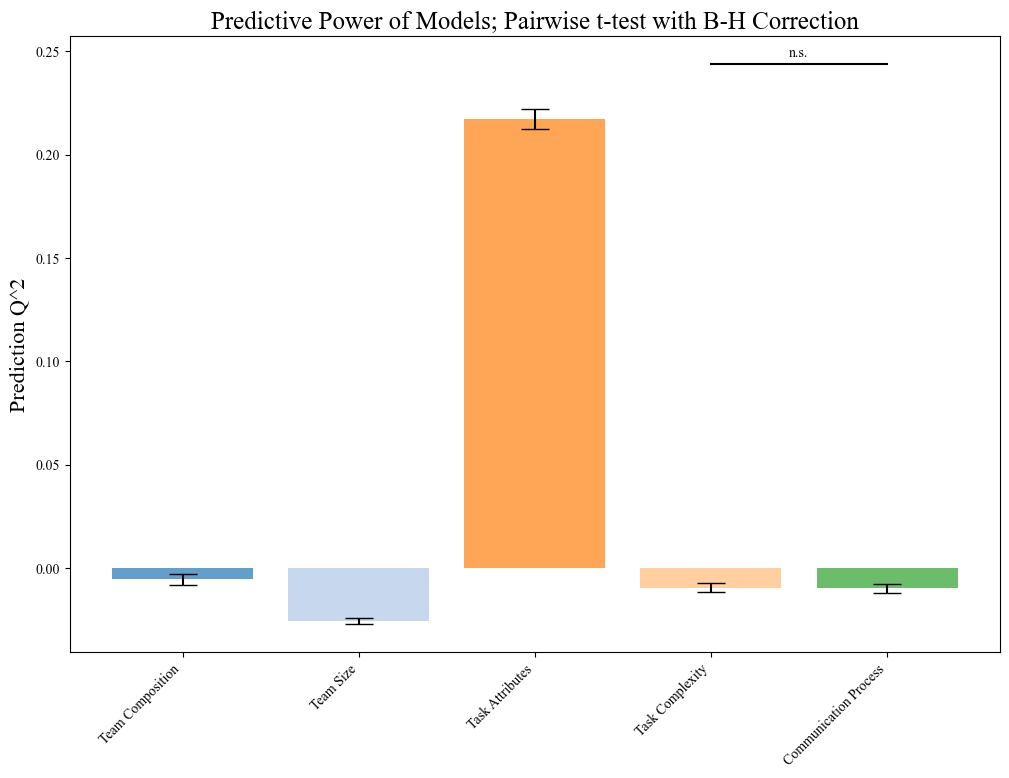

In [7]:
plot_means_with_confidence_intervals_and_ttests(evaluation_output_list, save_path)

# Variance in task versus performance for different cross-sections of the dataset

## Data visualization / Exploration of the full task data

In [8]:
full_multi_task_data = pd.read_csv('../tpm-data/raw_data/full_multi_task_data.csv').rename(columns={"task": "task_name"})

In [9]:
# This is all teams that played
team_multi_task_data = full_multi_task_data[full_multi_task_data["playerCount"]!=1]
# This is all individuals that played
individual_multi_task_data = full_multi_task_data[full_multi_task_data["playerCount"]==1]

In [10]:
# read in some scores from one of our pickle files
with open("./data_cache/multi_task_stageId_cumulative.pkl", "rb") as cleaned_pickle_file:
	stage_based_data = pickle.load(cleaned_pickle_file)


In [11]:
targets = stage_based_data.dvs
tasks = stage_based_data.task_name

In [12]:
# This just gives us the task and score associated with each row
tasks_and_scores = pd.concat([targets["score"],tasks], axis = 1)

## A few useful functions for visualizations

In [13]:
def sort_by_mean_abs(df):
    return df.reindex(df["Mean"].abs().sort_values(ascending=False).index)

def split_dataframes_and_get_col(df, grouper, col = "score"):    
    grouped_df = df.groupby(grouper)
    return([group_df[col] for group_name, group_df in grouped_df])

def split_dataframes_and_get_tasknames(df, grouper):    
    grouped_df = df.groupby(grouper)
    return([pd.unique(group_df[grouper])[0] for group_name, group_df in grouped_df])

def get_score_distribution(task_score_df, task_name="task_name"):
    mean_var_datasets = pd.DataFrame(
        {
            "Task": split_dataframes_and_get_tasknames(task_score_df, grouper = task_name),
            "Variance": [np.var(x) for x in split_dataframes_and_get_col(task_score_df, grouper = task_name)],
            "Mean": [np.mean(x) for x in split_dataframes_and_get_col(task_score_df, grouper = task_name)]
        }
    )
    return sort_by_mean_abs(mean_var_datasets)

def min_max_normalize(lst, source_list=None):
    if source_list is None:
        source_list = lst # By default, use the min and max from the target list. Otherwise, use the source_list to determine min and max.
    return [(x-np.min(source_list))/(np.max(source_list)-np.min(source_list)) for x in lst]

In [14]:
def task_to_marker(task, task_list):
    index = np.where(task_list == task)[0][0]
    markers = ['o', 's', '^', 'D', 'v', 'd', 'h', '+', 'p', '*']
    return markers[index]

def plot_task_mean_variance(df_means, df_with_complexity, plot_zero = False):

    """
    Plots the mean task performance on the x-axis, and the variance in task performance on the y-axis.

    @param df_means: a dataframe containing the performance per task (aggregated across all task instances.)
    We expect the following columns:
    - "Task" to contain task names;
    - "Mean" to contain the mean performance;
    - "Variance" to contain the variance in performance.

    @param df_with_complexity: a datafram containing the performance per task intance (complexity).
    We expect the following columns:
    - "task_name" to contain the task names;
    - "Task Complexity" to contain the level of task compexity, in {Low, Medium, High}
    - "Mean" to contain the mean performance;
    - "Variance" to contain the variance in performance.

    @param plot_zer (defaults to False) controls whether dotted lines should represent x=0/y=0.
    - By default, plots the medians.
    """

    # Plot first dataframe, containing the aggregated performance.
    plt.figure(figsize=(15, 15))

    # Set the list of tasks
    task_list = df_means["Task"].unique()

    for task in task_list:
        task_data = df_means[df_means["Task"] == task]
        plt.scatter(
            task_data["Mean"],
            task_data["Variance"],
            label=f"{task} Complexity",
            alpha=0.7,  # Adjust transparency if needed
            color = "gray",
            marker=task_to_marker(task, task_list),
            s=100
        )

    complexity_colors = {'Low': 'forestgreen', 'Medium': 'darkorange', 'High': 'firebrick'}
    legend_handles = []  # List to store legend handles

    for label in ["Low", "Medium", "High"]:
        label_data = df_with_complexity[df_with_complexity["Task_Complexity"] == label]
        complexity_legend_handle = None  # Store a single legend handle for each complexity level

        for task_with_complexity in task_list:
            task = task_with_complexity.split(' (')[0].strip()
            task_data = label_data[label_data["task_name"].str.startswith(task)]
            if not task_data.empty:
                marker = task_to_marker(task, task_list)
                scatter = plt.scatter(
                    task_data["Mean"],
                    task_data["Variance"],
                    alpha=0.5,
                    marker= marker,
                    s=100, 
                    c=complexity_colors[label],
                    label=None  # Don't include individual labels in the legend
                )

        # Create a single legend handle for each complexity level
        legend_handles.append(plt.Line2D([0], [0], marker='o', color=complexity_colors[label], label=f"{label} Complexity"))

    # Show a single legend for the entire plot
    plt.legend(handles=legend_handles)

    if plot_zero:
        plt.axhline(y=0, color='gray', linestyle='--')
        plt.axvline(x=0, color='gray', linestyle='--')
    else:
        plt.axhline(y=np.median(list(df_means["Variance"]) + list(df_with_complexity["Variance"])), color='gray', linestyle='--')
        plt.axvline(x=np.median(list(df_means["Mean"]) + list(df_with_complexity["Mean"])), color='gray', linestyle='--')

    # Annotate each point separately with larger text and centered above the dot
    for i, task in enumerate(df_means["Task"]):
        mean = df_means["Mean"].iloc[i]
        var = df_means["Variance"].iloc[i]
        plt.annotate(
            task,
            (mean, var),
            textcoords="offset points",
            xytext=(0, 25),
            ha='center',  # horizontally center text
            va='center',  # vertically center text
            fontsize=14   # set the font size
        )

    plt.xlabel("Mean Score", fontsize= 14)
    plt.ylabel("Variance in Score", fontsize= 14)
    plt.show()

## Score Distributions Across Tasks

In [15]:
# Teams
get_score_distribution(team_multi_task_data[["task_name", "score"]])

,Task,Variance,Mean
9,Writing Story,220.659607,92.151163
1,Divergent Association,130.744823,91.207289
7,Wolf Goat Cabbage,1159.523329,83.517413
4,Room Assignment,539.270895,81.404538
5,Sudoku,524.440350,76.977679
2,Guess the Correlation,611.407925,73.956284
3,Moral Reasoning,1068.850740,61.925287
0,Allocating Resources,1688.449437,61.081871
8,Word Construction,379.016663,49.696589
6,Whac a Mole,610.739214,21.134989


In [16]:
# Individuals
get_score_distribution(individual_multi_task_data[["task_name", "score"]])

,Task,Variance,Mean
9,Writing Story,476.307465,86.171938
1,Divergent Association,754.380814,77.156262
5,Sudoku,474.759136,69.461111
4,Room Assignment,1153.229378,68.238488
3,Moral Reasoning,1191.987358,60.858209
2,Guess the Correlation,762.986111,58.666667
0,Allocating Resources,2013.312222,50.433333
7,Wolf Goat Cabbage,2341.927424,48.780488
6,Whac a Mole,869.137366,32.654496
8,Word Construction,291.809215,18.844502


### Visualize Distributions for Individual / Team Performance

In [17]:
# Distribution of Individual Data

individual_multi_task_data["task_full"] = individual_multi_task_data["task_name"] + " (" + individual_multi_task_data["complexity"] + ")"
ind_multi_task_complexity = get_score_distribution(individual_multi_task_data, "task_full")
ind_multi_task_avg = get_score_distribution(individual_multi_task_data, "task_name")

# Distribution of Team Data

team_multi_task_data["task_full"] = team_multi_task_data["task_name"] + " (" + team_multi_task_data["complexity"] + ")"
team_multi_task_complexity = get_score_distribution(team_multi_task_data, "task_full")
team_multi_task_avg = get_score_distribution(team_multi_task_data, "task_name")

/var/folders/73/jl9lgbkj511fwjxkl9cvw7q00000gq/T/ipykernel_18593/3911824295.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  individual_multi_task_data["task_full"] = individual_multi_task_data["task_name"] + " (" + individual_multi_task_data["complexity"] + ")"
/var/folders/73/jl9lgbkj511fwjxkl9cvw7q00000gq/T/ipykernel_18593/3911824295.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  team_multi_task_data["task_full"] = team_multi_task_data["task_name"] + " (" + team_multi_task_data["complexity"] + ")

In [18]:
# Min-Max Normalize both Team and Individual Data

# Team
team_multi_task_complexity["Mean"] = min_max_normalize(list(team_multi_task_complexity["Mean"]), source_list = list(list(team_multi_task_complexity["Mean"])) + list(team_multi_task_avg["Mean"]))
team_multi_task_complexity["Variance"] = min_max_normalize(list(team_multi_task_complexity["Variance"]), source_list = list(list(team_multi_task_complexity["Variance"])) + list(team_multi_task_avg["Variance"]))
team_multi_task_avg["Mean"] = min_max_normalize(list(team_multi_task_avg["Mean"]), source_list = list(list(team_multi_task_complexity["Mean"])) + list(team_multi_task_avg["Mean"]))
team_multi_task_avg["Variance"] = min_max_normalize(list(team_multi_task_avg["Variance"]), source_list = list(list(team_multi_task_complexity["Variance"])) + list(team_multi_task_avg["Variance"]))

# Individual
ind_multi_task_complexity["Mean"] = min_max_normalize(list(ind_multi_task_complexity["Mean"]), source_list = list(list(ind_multi_task_complexity["Mean"])) + list(ind_multi_task_avg["Mean"]))
ind_multi_task_complexity["Variance"] = min_max_normalize(list(ind_multi_task_complexity["Variance"]), source_list = list(list(ind_multi_task_complexity["Variance"])) + list(ind_multi_task_avg["Variance"]))
ind_multi_task_avg["Mean"] = min_max_normalize(list(ind_multi_task_avg["Mean"]), source_list = list(list(ind_multi_task_complexity["Mean"])) + list(ind_multi_task_avg["Mean"]))
ind_multi_task_avg["Variance"] = min_max_normalize(list(ind_multi_task_avg["Variance"]), source_list = list(list(ind_multi_task_complexity["Variance"])) + list(ind_multi_task_avg["Variance"]))

In [19]:
# Task Aggregate: Individual minus Team
task_varmean_df = ind_multi_task_avg
task_varmean_df[["Mean", "Variance"]] = ind_multi_task_avg[["Mean", "Variance"]]-team_multi_task_avg[["Mean", "Variance"]]

# Task Instance Data: Individual minus Team
score_distr_by_complexity = ind_multi_task_complexity
score_distr_by_complexity[["Mean", "Variance"]] = ind_multi_task_complexity[["Mean", "Variance"]]-team_multi_task_complexity[["Mean", "Variance"]]

In [20]:
# Break up the compount Task Name (complexity) into two columns for plotting
score_distr_by_complexity[['task_name', 'Task_Complexity']] = score_distr_by_complexity['Task'].str.extract(r'(.*)\((.*?)\)')

### Individual v. Team Performance (Min-Max Normalized)

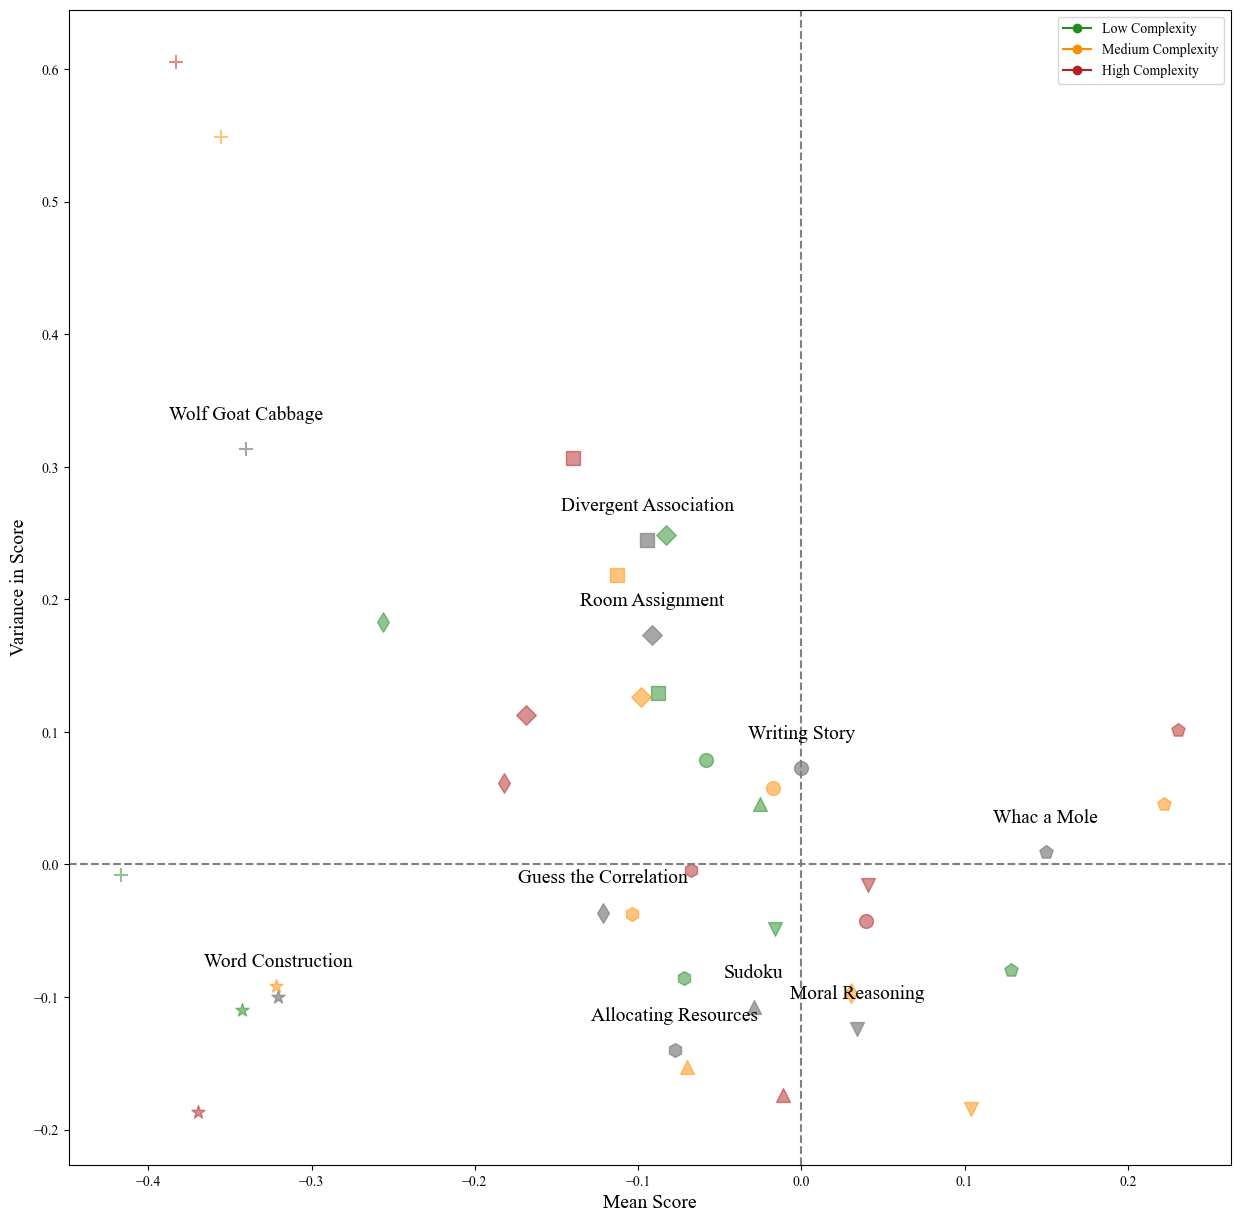

In [21]:
plot_task_mean_variance(task_varmean_df, score_distr_by_complexity, plot_zero=True)

# Relationships between task similarity and performance

- pick a task we will call the reference task
- X axis is the distance of a bunch of tasks (say 4 tasks) from the reference task
- Y axis some team outcome (eg overall performance, difference in performance between teams and individuals, number of chat messages, average efficiency, turn taking, etc)
- One plot per Y outcome
- To show that distance in task space leads to performance and behavioral changes

In [22]:
full_multi_task_data

,task_name,complexity,stageId,playerCount,score
0,Room Assignment,Low,qoDoJsu9TrxfSypEg,3,86.000000
1,Room Assignment,Medium,6jxnm8hTtviJ5xjKh,3,74.000000
2,Room Assignment,High,jJLH2qa5JnwsKjKe7,3,71.134021
3,Wolf Goat Cabbage,Low,ttXXwrucKPzrTAnxR,3,100.000000
4,Wolf Goat Cabbage,Medium,iuW5vHY36vwGn47Wk,3,100.000000
...,...,...,...,...,...
3669,Wolf Goat Cabbage,High,SeCiuv8q2JyzoHiTZ,1,100.000000
3670,Wolf Goat Cabbage,Low,68BGNjmqKyqCM7RkL,1,78.000000
3671,Allocating Resources,Medium,4tasgKw63QRQZjKbB,1,100.000000
3672,Allocating Resources,High,KoJgJoLFJ49XtPq2D,1,90.000000
